In [7]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import networkx as nx

import torch
# !pip install torch_geometric
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GATConv

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)

In [2]:
#Read in pass data
pass_modelling_data = pd.read_excel('C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\pass_data_modelling.xlsx')
pass_modelling_data.head()

#Map every player name to the team name
player_team_mapping = dict(zip(pass_modelling_data['player_name'], pass_modelling_data['team_name']))
#Apply mapping to get team name of pass recipient 
pass_modelling_data['pass_recipient_team'] = pass_modelling_data['pass_recipient'].map(player_team_mapping)

In [3]:
#List of categorical columns to convert
categorical_cols = ['poistion', 'play_pattern', 'pass_height_name',
       'pass_body_part', 'pass_type', 'pass_technique']

#We are not converting the following columns due to creation of edges
#'team_name', 'opposing_team', 'player_name','pass_recipient_team', 'pass_recipient'

pass_data_one_hot = pd.get_dummies(pass_modelling_data, columns=categorical_cols, drop_first=True)

#Convert time string to seconds
def time_to_seconds(time_col):
    minutes, seconds = map(int, time_col.split(':'))
    total_seconds = minutes * 60 + seconds
    return total_seconds

pass_data_one_hot['match_time_sec'] = pass_data_one_hot['time'].apply(time_to_seconds)

#Replace blanks in column names with _
pass_data_one_hot.columns = pass_data_one_hot.columns.str.replace(' ','_')

pass_data_one_hot = pass_data_one_hot.drop(['Unnamed:_0','time'],axis=1)

#Convery binary column to int
binary_cols = ['under_pressure','pass_cross','pass_switch','pass_through_ball','pass_goal_assist','pass_shot_assist','pass_outcome',
              'player1', 'player2', 'player3', 'player4', 'player5', 'player6', 'player7', 'player8', 'player9', 'player10',
              'player11', 'player12', 'player13', 'player14', 'player15', 'player16', 'player17', 'player18', 'player19',
              'player20', 'player21']
pass_data_one_hot[binary_cols] = pass_data_one_hot[binary_cols].astype(np.int32)

#Replacing values with no pass recipient as 'out'
pass_data_one_hot['pass_recipient'] = pass_data_one_hot['pass_recipient'].fillna("Out")

In [4]:
#Create pass id column
pass_data_one_hot['pass_id'] = pass_data_one_hot['match_id'].astype(str) + "_" + pass_data_one_hot['match_time_sec'].astype(str) + "_" + pass_data_one_hot['player_name'].str.replace(' ', '', regex=False) + "_" + pass_data_one_hot['pass_recipient'].str.replace(' ', '', regex=False)

pass_data = pass_data_one_hot.sort_values(by= 'pass_id')

#Move 'pass_id' to the first column
cols = ['pass_id'] + [col for col in pass_data.columns if col != 'pass_id']
pass_data = pass_data[cols]

pass_data.head()

,pass_id,match_id,team_name,opposing_team,player_name,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,pass_recipient_team,poistion_Center_Back,poistion_Center_Defensive_Midfield,poistion_Center_Forward,poistion_Left_Attacking_Midfield,poistion_Left_Back,poistion_Left_Center_Back,poistion_Left_Center_Forward,poistion_Left_Center_Midfield,poistion_Left_Defensive_Midfield,poistion_Left_Midfield,poistion_Left_Wing,poistion_Left_Wing_Back,poistion_Right_Attacking_Midfield,poistion_Right_Back,poistion_Right_Center_Back,poistion_Right_Center_Forward,poistion_Right_Center_Midfield,poistion_Right_Defensive_Midfield,poistion_Right_Midfield,poistion_Right_Wing,poistion_Right_Wing_Back,play_pattern_From_Counter,play_pattern_From_Free_Kick,play_pattern_From_Goal_Kick,play_pattern_From_Keeper,play_pattern_From_Kick_Off,play_pattern_From_Throw_In,play_pattern_Other,play_pattern_Regular_Play,pass_height_name_High_Pass,pass_height_name_Low_Pass,pass_body_part_Left_Foot,pass_body_part_No_Touch,pass_body_part_Other,pass_body_part_Right_Foot,pass_type_Kick_Off,pass_type_Normal,pass_type_Recovery,pass_technique_Unknown,match_time_sec
0,3893787_0_JacquelineAnneHand_MaliaGraceSteinmetz,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,0,0,0,0,0,1,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0,0,New Zealand Women's,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,0
119,3893787_1002_JulieBlakstad_TuvaHansen,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,0.1,15.8,3.8,1,13.7,3.6,2.1,-3.0,Tuva Hansen,0,0,0,0,0,0,0,3.8,38.6,1,6.2,20.3,0,7.5,21.6,1,7.6,6.5,1,9.7,12.6,0,10.7,8.9,1,11.7,37.9,0,13.1,4.0,0,22.5,6.4,0,23.0,17.1,1,23.7,17.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,Norway Women's,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,True,1002
120,3893787_1005_MaliaGraceSteinmetz_HannahWilkinson,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,0.9,97.8,68.4,0,103.6,69.6,5.9,0.2,Hannah Wilkinson,0,0,0,0,0,1,1,98.1,72.1,0,98.7,67.8,0,103.7,73.8,0,105.5,65.2,1,105.7,76.1,0,105.8,30.4,0,107.3,45.2,1,107.5,67.6,1,107.6,59.5,0,110.0,58.3,1,110.6,69.9,0,117.5,41.6,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,New Zealand Women's,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True,1005
121,3893787_1007_HannahWilkinson_Indiah-PaigeJanit...,3893787,New Zealand Women's,Norway Women's,Hannah Wilkinson,1

In [5]:
#Spilt df into test and train data
train_data, test_data = train_test_split(pass_data, test_size=0.2, random_state=42, stratify=pass_data['pass_outcome'])  #80% train, 20% test

In [47]:
#Preapre node features of the data
def prepare_node_features(df):
    
    df = df.iloc[:, [6, 7, 8, 9, 10, 14, 15, 16, 17, 18] + list(range(20, 83)) + list(range(84, 123))] #select only columns used for node features

    #Create intial empty list to store features
    node_features_list = []
    
    #Look through all columns in data to ensure correct type and size
    for column in df.columns:
        if df[column].dtype in ['int64', 'int32', 'float64']:
            node_features_list.append(torch.tensor(df[column].values, dtype=torch.float).unsqueeze(1))  #Unsqueeze to 2D shape
        elif df[column].dtype == 'bool':
            node_features_list.append(torch.tensor(df[column].astype(int).values, dtype=torch.float).unsqueeze(1))
        else:
            pass

    #Join all columns together in list
    node_features = torch.cat(node_features_list, dim=1)
    return node_features

#Apply function to create train and test data
node_features_train = prepare_node_features(train_data)
node_features_test = prepare_node_features(test_data)

print(node_features_train)
print(node_features_test)

tensor([[ 81.7000,  55.2000,   0.0000,  ...,   1.0000,   0.0000,   1.0000],
        [ 32.3000,  45.5000,   0.0000,  ...,   1.0000,   0.0000,   1.0000],
        [ 39.6000,  63.3000,   0.0000,  ...,   1.0000,   0.0000,   1.0000],
        ...,
        [ 68.9000,  31.0000,   0.0000,  ...,   1.0000,   0.0000,   1.0000],
        [ 31.9000,  27.4000,   0.0000,  ...,   1.0000,   0.0000,   1.0000],
        [116.6000,  52.8000,   0.0000,  ...,   0.0000,   1.0000,   1.0000]])
tensor([[ 3.6000, 40.1000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
        [80.0000, 61.6000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
        [73.5000, 14.0000,  0.0000,  ...,  0.0000,  1.0000,  1.0000],
        ...,
        [69.4000, 14.6000,  0.0000,  ...,  0.0000,  1.0000,  1.0000],
        [49.9000, 27.5000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
        [94.4000, 40.2000,  0.0000,  ...,  1.0000,  0.0000,  0.0000]])


In [48]:
node_features_train.shape

torch.Size([36997, 112])

In [49]:
#Compute the edge weights and index or the data
def compute_edge_weights_and_index(df):
    edge_index = []
    edge_weights = []
    labels = []

    #Iterate through every row
    for i, row in df.iterrows():
        team_name = row['team_name']
        pass_recipient_team = row['pass_recipient_team']
        passer_name = row['player_name']
        pass_recipient = row['pass_recipient']
        pass_length = row['pass_length']
        pass_angle = row['pass_angle']
        pass_id = row['pass_id']
        
        #Calculate edge weight with pass angle and pass length
        edge_weight = (pass_length + 1e-6) * (1 + np.abs(pass_angle))
        
        # If players are from the same team, use positive weight (encourage passing)
        if team_name == pass_recipient_team: #If same team as passer than weight is positive
            edge_weight = edge_weight
        else:  #If different team than passer than weight is negative
            edge_weight = -edge_weight
            
        #Get index of passer and reciever
        passer_index = df[df['player_name'] == passer_name].index[0]
        receiver_index = df[df['pass_recipient'] == pass_recipient].index[0]
        
        #Add the indices and weights to corresponding lists
        edge_index.append([passer_index, receiver_index])
        edge_weights.append(edge_weight)
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    return edge_index, edge_weights

#Create edge weights and indices for train and test data
edge_index_train, edge_weights_train  = compute_edge_weights_and_index(train_data)
edge_index_test, edge_weights_test = compute_edge_weights_and_index(test_data)

In [50]:
def reindex_edges(df_train, df_test, edge_index_train, edge_index_test):
    #Map old indices to new indices
    train_node_mapping = {node: idx for idx, node in enumerate(df_train['player_name'].unique())}
    test_node_mapping = {node: idx for idx, node in enumerate(df_test['player_name'].unique())}
    
    #Re-index edges for train data
    new_edge_index_train = []
    for edge in edge_index_train.t().cpu().numpy():
        start_node, end_node = edge
        new_edge_index_train.append([train_node_mapping.get(start_node, -1), train_node_mapping.get(end_node, -1)])
    
    #Re-index edges for test data
    new_edge_index_test = []
    for edge in edge_index_test.t().cpu().numpy():
        start_node, end_node = edge
        new_edge_index_test.append([test_node_mapping.get(start_node, -1), test_node_mapping.get(end_node, -1)])
        
    edge_index_train = torch.tensor(new_edge_index_train, dtype=torch.long).t().contiguous()
    edge_index_test = torch.tensor(new_edge_index_test, dtype=torch.long).t().contiguous()
    return edge_index_train, edge_index_test

#Create new index list for test and train after re-index 
edge_index_train, edge_index_test = reindex_edges(train_data, test_data, edge_index_train, edge_index_test)


In [51]:
#Create y target columns for train and test
y_train = torch.tensor(train_data['pass_outcome'].values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_data['pass_outcome'].values, dtype=torch.float).view(-1, 1)

#Create graph model train data
graph_train_data = Data(
    x= node_features_train,
    edge_index=edge_index_train,
    edge_attr=edge_weights_train,
    y=y_train
)

#Create graph model test data
graph_test_data = Data(
    x= node_features_test,
    edge_index=edge_index_test,
    edge_attr=edge_weights_test,
    y=y_test
)
print(graph_train_data)
print(graph_test_data)

Data(x=[36997, 112], edge_index=[2, 36997], edge_attr=[36997], y=[36997, 1])
Data(x=[9250, 112], edge_index=[2, 9250], edge_attr=[9250], y=[9250, 1])


In [52]:
#Create class for GAT model creation
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_heads):
        super(GATModel, self).__init__()
        
        #Define the GAT layers in model
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.3)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=0.3)
        
        #Fully connected layer to predict probability of pass completion
        self.fc = torch.nn.Linear(out_channels, 1)  #Output of probability

    def forward(self, x, edge_index, edge_attr=None):
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)  #Activation function
        x = self.gat2(x, edge_index, edge_attr)
        x = self.fc(x)

        #Sigmoid activation to get probability
        return torch.sigmoid(x)


GATModel(
  (gat1): GATConv(112, 128, heads=5)
  (gat2): GATConv(640, 1, heads=1)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)
Epoch 0, Train Loss: 3.5183963775634766, Train Accuracy: 53.38%
Epoch 0, Test Loss: 1.346267580986023, Test Accuracy: 62.98%
Epoch 10, Train Loss: 1.0099636316299438, Train Accuracy: 62.87%
Epoch 10, Test Loss: 0.9955458045005798, Test Accuracy: 59.88%
Epoch 20, Train Loss: 0.8421778678894043, Train Accuracy: 64.88%
Epoch 20, Test Loss: 0.8312154412269592, Test Accuracy: 63.44%
Epoch 30, Train Loss: 0.7261243462562561, Train Accuracy: 66.68%
Epoch 30, Test Loss: 0.7202011942863464, Test Accuracy: 66.38%
Epoch 40, Train Loss: 0.6349005103111267, Train Accuracy: 69.28%
Epoch 40, Test Loss: 0.6307129859924316, Test Accuracy: 69.79%
Epoch 50, Train Loss: 0.5677856802940369, Train Accuracy: 73.11%
Epoch 50, Test Loss: 0.5690301656723022, Test Accuracy: 73.37%
Epoch 60, Train Loss: 0.5222378969192505, Train Accuracy: 75.17%
Epoch 60, Test Loss: 0.525207

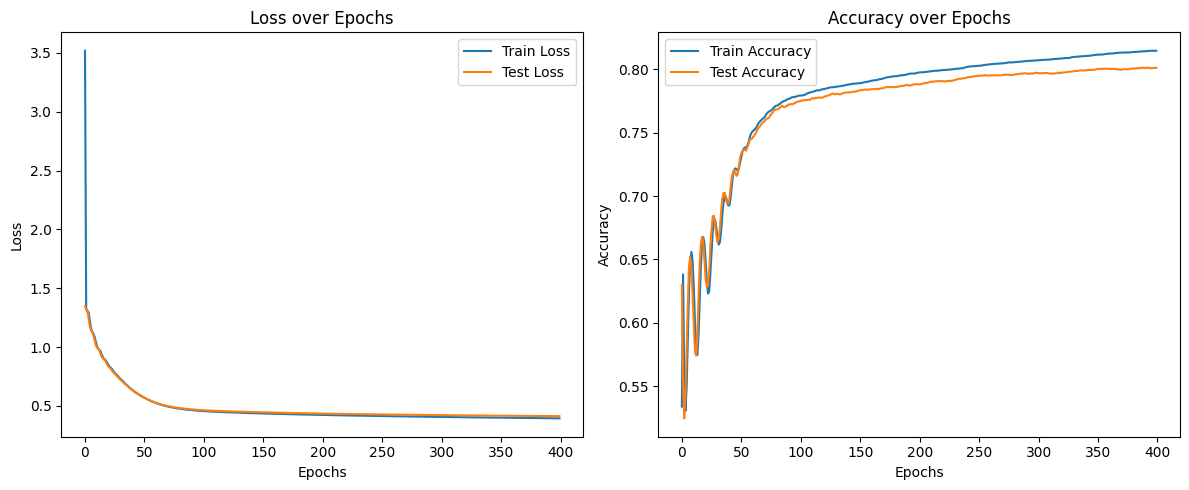

In [58]:
#Create empty intial lists for accuracies and losses 
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

#Use class defined previously to create model
model = GATModel(in_channels= graph_train_data.x.size(1), out_channels=1, hidden_channels=128, num_heads=5)
print(model)

#Loss function and optimizer creation
criterion = torch.nn.BCELoss() #Binary Cross-Entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Begin model training
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(graph_train_data.x, graph_train_data.edge_index, graph_train_data.edge_attr)
    loss = criterion(out.squeeze(), graph_train_data.y.squeeze()) #Compute loss at each epoch
    loss.backward()
    optimizer.step()
    
    #Convert outputs to binary predictions
    pred = (out > 0.5).float() #If output > 0.5, classify as 1, else 0
    
    #Compute accuracy at each epoch
    correct = (pred.squeeze() == graph_train_data.y.squeeze()).sum().item()
    accuracy_train = correct / len(graph_train_data.y)
    #Add loss and accuracy to empty lists
    train_losses.append(loss.item())
    train_accuracies.append(accuracy_train)
    
    #Evalute model with test data
    model.eval()
    with torch.no_grad():
        test_out = model(graph_test_data.x, graph_test_data.edge_index, graph_test_data.edge_attr)
        test_loss = criterion(test_out.squeeze(), graph_test_data.y.squeeze())
        
        pred_test = (test_out > 0.5).float() 

        correct_test = (pred_test.squeeze() == graph_test_data.y.squeeze()).sum().item()
        accuracy_test = correct_test / len(graph_test_data.y)
    
        #Add loss and accuracy to empty lists
        test_losses.append(test_loss.item())
        test_accuracies.append(accuracy_test)
    
    #Print training and test loss and accuracy every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Train Accuracy: {accuracy_train * 100:.2f}%')
        print(f'Epoch {epoch}, Test Loss: {test_loss.item()}, Test Accuracy: {accuracy_test * 100:.2f}%')

#Plotting training and testing loss and accuracy
#Loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
#Obtain model scores
precision_test = precision_score(graph_test_data.y, pred_test.squeeze(), average='binary')
precision_train = precision_score(graph_train_data.y, pred.squeeze(), average='binary')
recall_test = recall_score(graph_test_data.y, pred_test.squeeze(), average='binary')
recall_train = recall_score(graph_train_data.y, pred.squeeze(), average='binary')
f1_test = f1_score(graph_test_data.y, pred_test.squeeze(), average='binary')
f1_train = f1_score(graph_train_data.y, pred.squeeze(), average='binary')

print("Test Precision:", round(precision_test,3))
print("Train Precision:", round(precision_train,3))
print("Test Recall:", round(recall_test,3))
print("Train Recall:", round(recall_train,3))
print("Test F1 Score:", round(f1_test,3))
print("Train F1 Score:", round(f1_train,3))


Test Precision: 0.829
Train Precision: 0.84
Test Recall: 0.926
Train Recall: 0.931
Test F1 Score: 0.875
Train F1 Score: 0.883


In [60]:
#Set up Explainer with GNNExplainer in order to see feature importance
explainer = Explainer(
    model=model, #Pre-trained model defined above
    algorithm=GNNExplainer(epochs=400),
    explanation_type='model',  
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node', #Node-level explanation
        return_type='probs', #Model returns probabilities after sigmoid
    ),
)

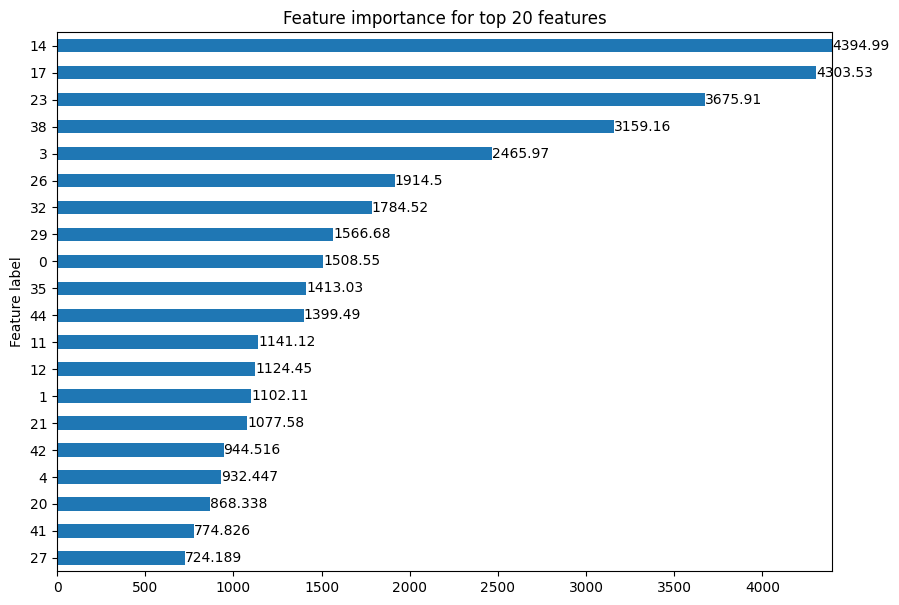

In [61]:
#Explain for all nodes in the graph
explanation = explainer(graph_test_data.x, graph_test_data.edge_index)

#Plot top 20 features in model
explanation.visualize_feature_importance(top_k=20)